In [12]:
# All Imports#
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
%matplotlib inline
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load Training Data

In [13]:
#### Read in our vehicles and non-vehicles ####

car_images = glob.glob('training_data/vehicles/**/*.png', recursive=True)
notcar_images=glob.glob('training_data/non-vehicles/**/*.png', recursive=True)
cars = []
notcars = []

for image in car_images:
        cars.append(image)
for image in notcar_images:
        notcars.append(image)

print (len(cars))
print (len(notcars))

8792
8968


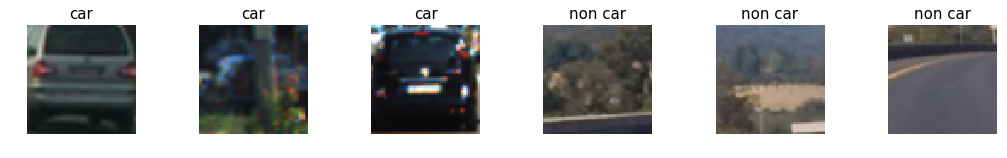

In [14]:
# Visualise Few Samples from Data

fig, axs = plt.subplots(1,6, figsize=(18, 2))

for i in np.arange(3):
    img = mpimg.imread(car_images[np.random.randint(0,len(car_images))])
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=15)
    axs[i].imshow(img)
for i in np.arange(3,6):
    img = mpimg.imread(notcar_images[np.random.randint(0,len(notcar_images))])
    axs[i].axis('off')
    axs[i].set_title('non car', fontsize=15)
    axs[i].imshow(img)
    plt.savefig('output_images/data_visualization.png', 
            bbox_inches="tight")

In [15]:
#### Function to get HOG features on a single image ####

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False,block_norm='L2-Hys')
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec,block_norm='L2-Hys')
    return features
print ('#')

#


In [16]:
#### Function to get Spatial features on a single image ####
def bin_spatial_single(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))                     
print ('#')

#


In [17]:
#### Function to get Color Histogram features on a single image ####
def color_hist_single(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
print ('#')

#


# Visualise HOG on Sample Image

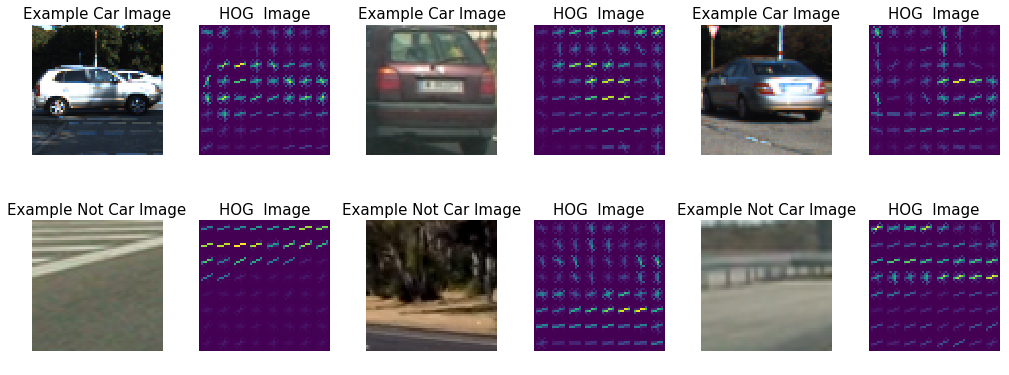

In [18]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
carind=[]
notcarind=[]
fig, axs = plt.subplots(2,6, figsize=(18, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

for i in np.arange(3):
    # Generate a random index to look at a car  and not car image
    carind =np.random.randint(0, len(cars))
    notcarind = np.random.randint(0, len(notcars))
    # Read in the image
    carimage = cv2.imread(cars[carind])
    cargray = cv2.cvtColor(carimage, cv2.COLOR_BGR2GRAY)
    notcarimage = cv2.imread(notcars[notcarind])
    notcargray = cv2.cvtColor(notcarimage, cv2.COLOR_BGR2GRAY)
    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(cargray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


    features_1, hog_image_1 = get_hog_features(notcargray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    notcarimage = cv2.cvtColor(notcarimage, cv2.COLOR_BGR2RGB)
    carimage = cv2.cvtColor(carimage, cv2.COLOR_BGR2RGB)
    axs[0][2*i].axis('off')
    axs[0][2*i].set_title('Example Car Image', fontsize=15)
    axs[0][2*i].imshow(carimage)
    axs[0][2*i+1].axis('off')
    axs[0][2*i+1].set_title('HOG  Image', fontsize=15)
    axs[0][2*i+1].imshow(hog_image)
    axs[1][2*i].axis('off')
    axs[1][2*i].set_title('Example Not Car Image', fontsize=15)
    axs[1][2*i].imshow(notcarimage)
    axs[1][2*i+1].axis('off')
    axs[1][2*i+1].set_title('HOG  Image', fontsize=15)
    axs[1][2*i+1].imshow(hog_image_1)

In [19]:
# Define a function to compute binned color features  
def bin_spatial(img, color_space= 'RGB', size=(32, 32)):          
        
    # Use cv2.resize().ravel() to create the feature vector    
    features = cv2.resize(img,size).ravel() # Remove this line!
    # Return the feature vector
    #print(len(features))
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, vis=False, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[0:len(bin_edges)-1]+bin_edges[1:])/2
#     Return the individual histograms, bin_centers and feature vector
#     print ('Hist Feature Shape:')
#     print (hist_features.shape)
    if vis == True:
        return channel1_hist,channel2_hist,channel3_hist,bin_centers
    else:
        return hist_features

# Visualise Color Histogram on Sample Image

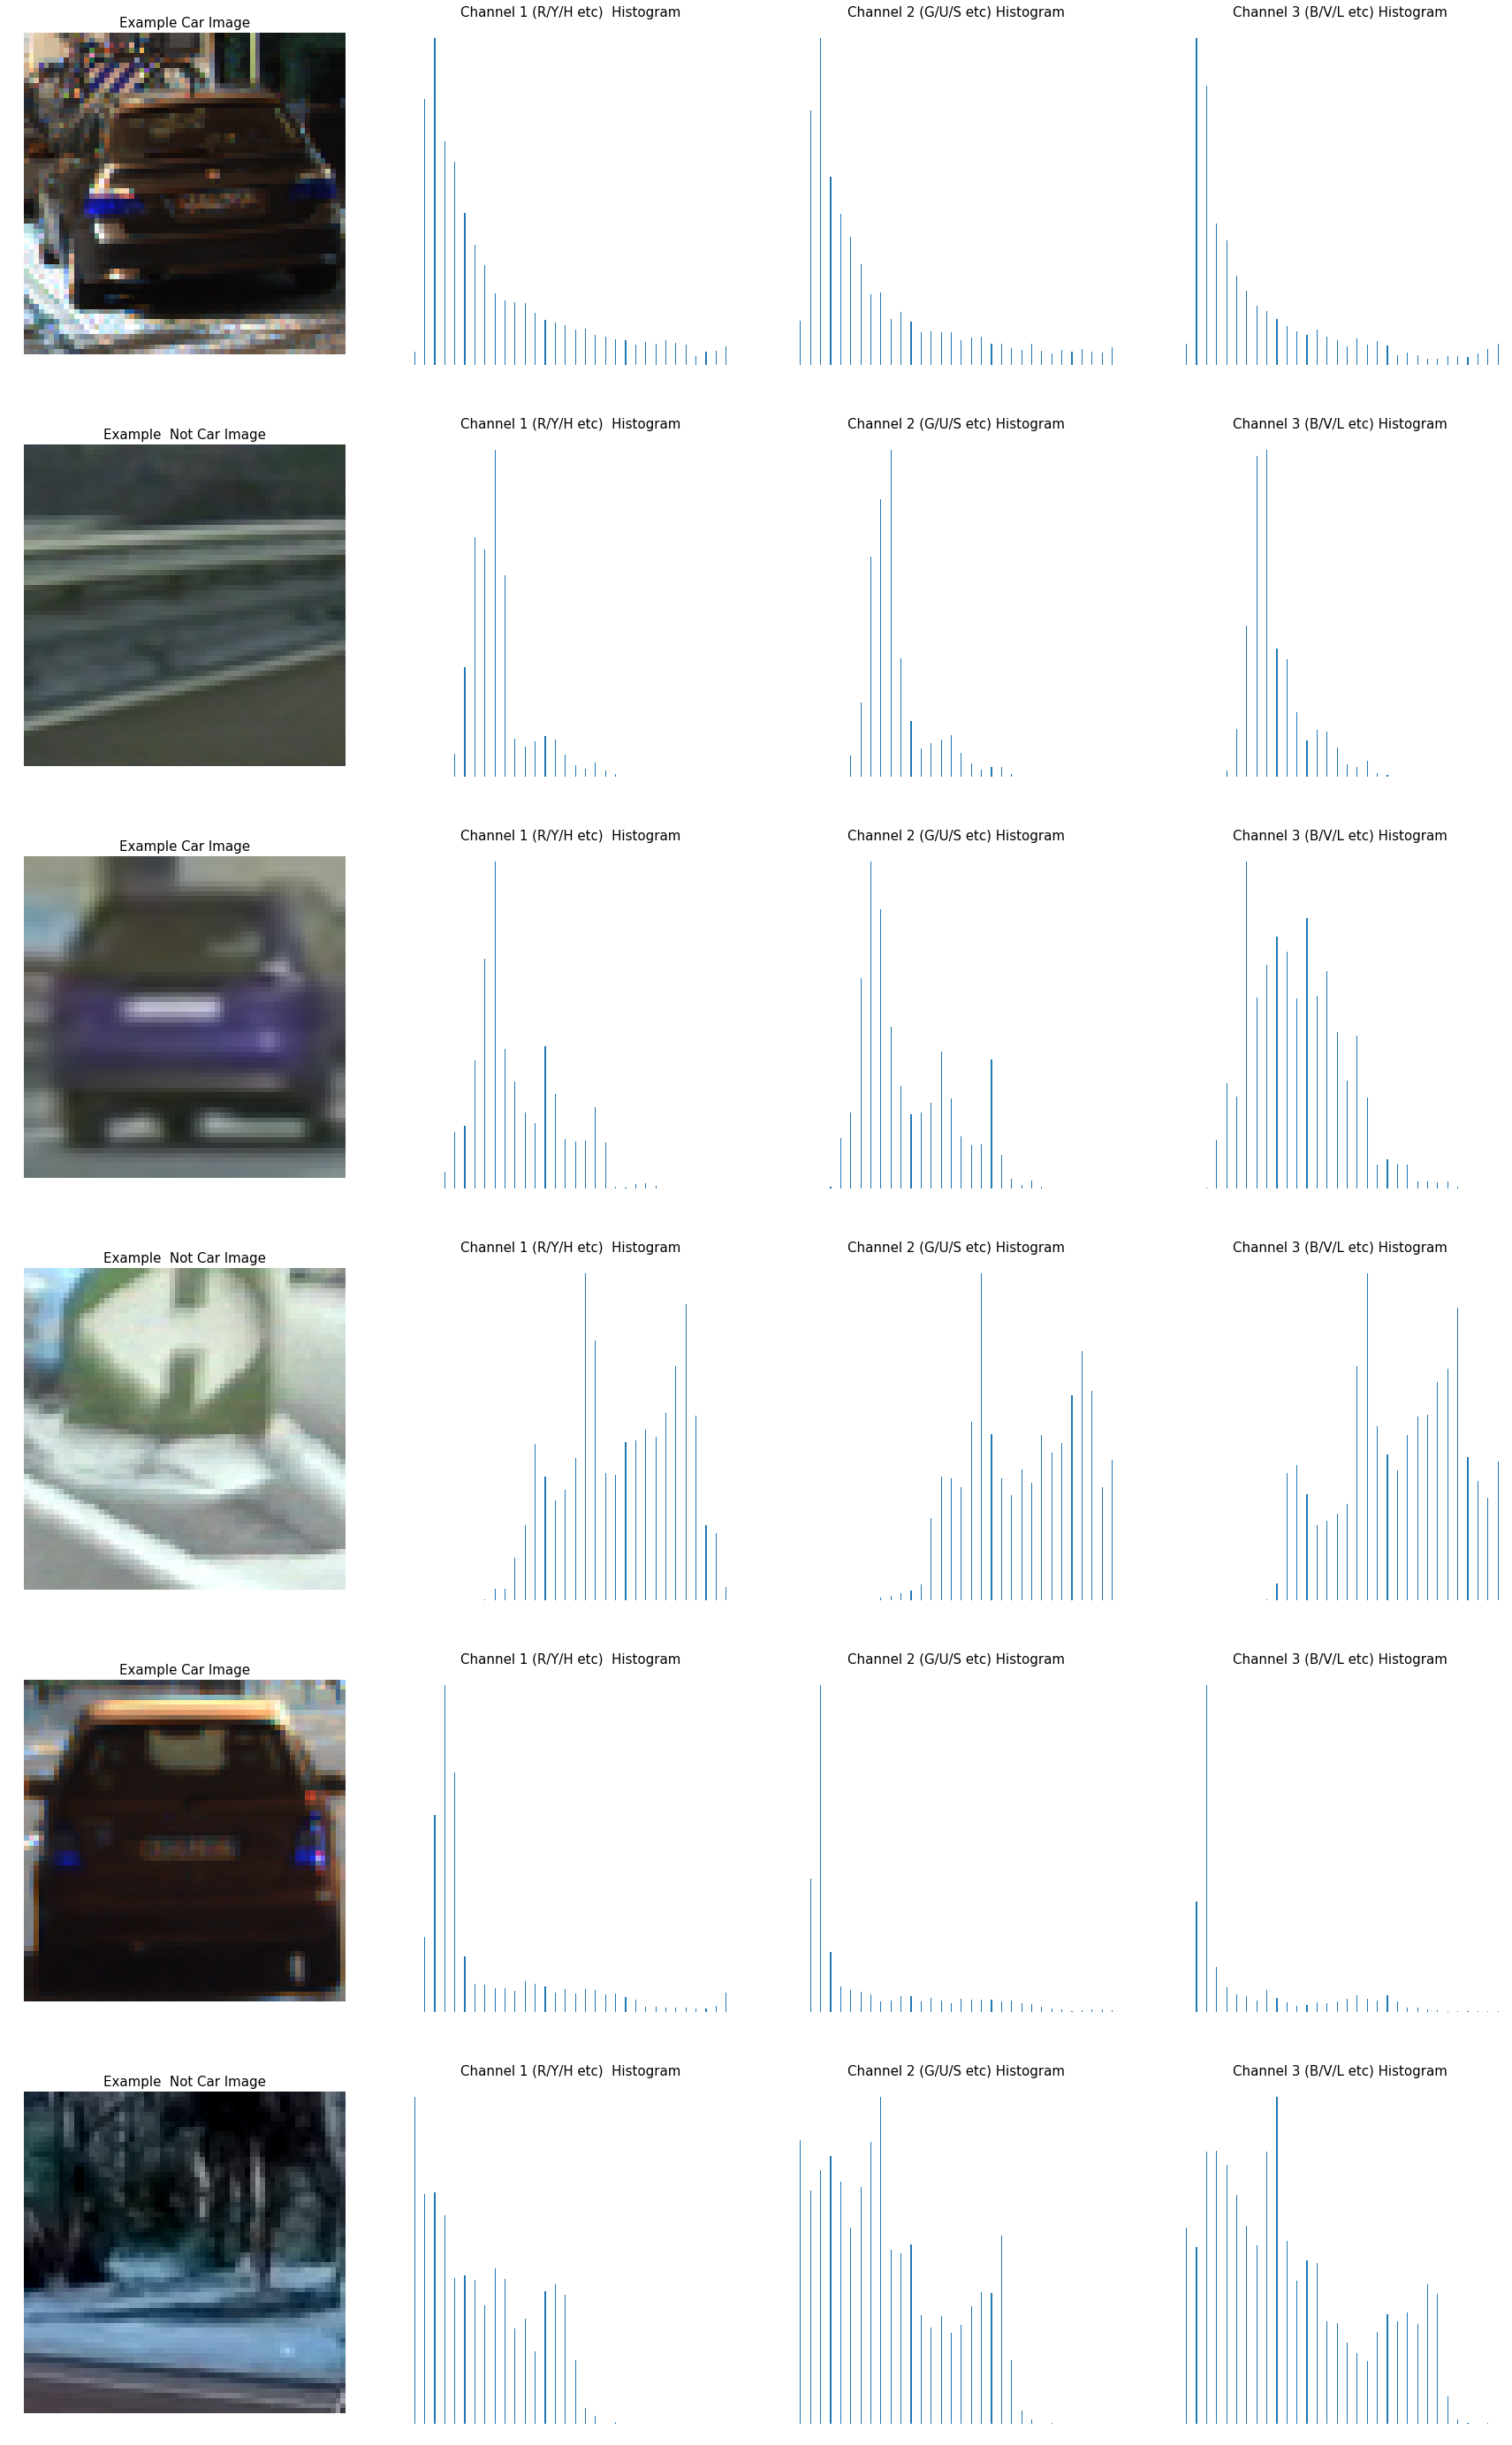

In [20]:
# Define Paramters for Color Histogram ##
n_bins = 32
bins_range=(0, 256)
carind=[]
notcarind=[]
fig, axs = plt.subplots(6,4, figsize=(30, 50))
#fig.subplots_adjust(hspace = 1, wspace=.001)

for i in np.arange(3):
    # Generate a random index to look at a car  and not car image
    carind =np.random.randint(0, len(cars))
    notcarind = np.random.randint(0, len(notcars))
    # Read in the image
    carimage = cv2.imread(cars[carind])
    notcarimage = cv2.imread(notcars[notcarind])
    # Call function to generate histogram features
    channel1_hist,channel2_hist,channel3_hist,bin_centers = color_hist(carimage,n_bins,vis=True)
    n =2*i
    #fig.tight_layout()
    axs[n][0].axis('off')
    axs[n][0].set_title('Example Car Image', fontsize=15)
    axs[n][0].imshow(carimage)
    
    axs[n][1].axis('off')
    axs[n][1].set_title('Channel 1 (R/Y/H etc)  Histogram', fontsize=15)
    axs[n][1].bar(bin_centers, channel1_hist[0])
    axs[n][1].set_xlim(0, 256)
    
    axs[n][2].axis('off')
    axs[n][2].set_title('Channel 2 (G/U/S etc) Histogram', fontsize=15)
    axs[n][2].bar(bin_centers, channel2_hist[0])
    axs[n][2].set_xlim(0, 256)
    
    axs[n][3].axis('off')
    axs[n][3].set_title('Channel 3 (B/V/L etc) Histogram ', fontsize=15)
    axs[n][3].bar(bin_centers, channel3_hist[0])
    axs[n][3].set_xlim(0, 256)
    
    
    channel1_hist,channel2_hist,channel3_hist,bin_centers = color_hist(notcarimage,n_bins,vis=True)
    
    axs[n+1][0].axis('off')
    axs[n+1][0].set_title('Example  Not Car Image', fontsize=15)
    axs[n+1][0].imshow(notcarimage)
    
    axs[n+1][1].axis('off')
    axs[n+1][1].set_title('Channel 1 (R/Y/H etc)  Histogram', fontsize=15)
    axs[n+1][1].bar(bin_centers, channel1_hist[0])
    axs[n+1][1].set_xlim(0, 256)
    
    axs[n+1][2].axis('off')
    axs[n+1][2].set_title('Channel 2 (G/U/S etc) Histogram', fontsize=15)
    axs[n+1][2].bar(bin_centers, channel2_hist[0])
    axs[n+1][2].set_xlim(0, 256)
    
    axs[n+1][3].axis('off')
    axs[n+1][3].set_title('Channel 3 (B/V/L etc) Histogram ', fontsize=15)
    axs[n+1][3].bar(bin_centers, channel3_hist[0])
    axs[n+1][3].set_xlim(0, 256)

# Visualise Spatial Bins

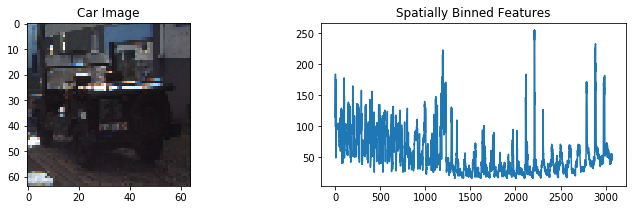

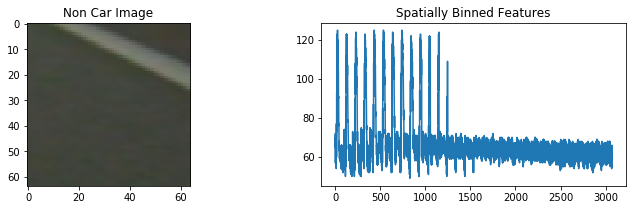

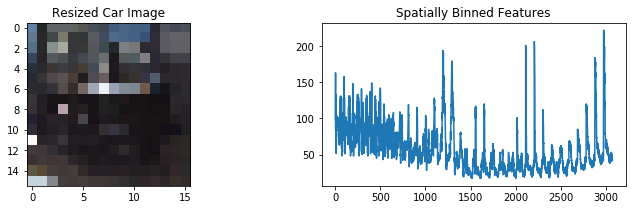

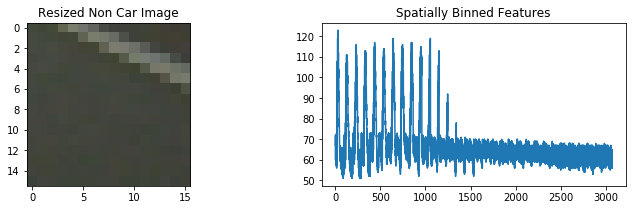

In [21]:
color_space='YCrCb'
size=(32, 32)
# Generate a random index to look at a car  and not car image
carind =np.random.randint(0, len(cars))
notcarind = np.random.randint(0, len(notcars))
# Read in the image
carimage = cv2.imread(cars[carind])
notcarimage = cv2.imread(notcars[notcarind])

feature_vec = bin_spatial(carimage,color_space, size)
feature_vec_1 = bin_spatial(notcarimage,color_space, size)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(carimage)
plt.title('Car Image')
plt.subplot(122)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(notcarimage)
plt.title('Non Car Image')
plt.subplot(122)
plt.plot(feature_vec_1)
plt.title('Spatially Binned Features')

small_carimg = cv2.resize(carimage, (16, 16))
small_notcarimg = cv2.resize(notcarimage, (16, 16))

feature_vec = bin_spatial(small_carimg,color_space, size)
feature_vec_1 = bin_spatial(small_notcarimg,color_space, size)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(small_carimg)
plt.title('Resized Car Image')
plt.subplot(122)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(small_notcarimg)
plt.title('Resized Non Car Image')
plt.subplot(122)
plt.plot(feature_vec_1)
plt.title('Spatially Binned Features')

# Combine Features

In [22]:
# Define a function to extract features from a list of images 
# Have this function call bin_spatial() and color_hist() Referred from Lesson 34 https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/40ac880a-7ccc-4145-a864-6b0b99ea31e9
def extract_features(imgs, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'BGR':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

print ('#')

#


# Train and Test Classifier Accuracy on an Image Set

In [23]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 32
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

t=time.time()
car_features = extract_features(cars, color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=(spatial,spatial),hist_bins=histbin)
notcar_features = extract_features(notcars,color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=(spatial,spatial),hist_bins=histbin)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

196.4 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
38.49 Seconds to train SVC...
Test Accuracy of SVC =  0.9899
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
0.02018 Seconds to predict 10 labels with SVC


# Method for Using Classifier to Detect Cars in an Image

Also Added Spatial Bin and Histogram Classification for SVC Prediction

In [110]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space):
    
    rectangles=[] # List to add all rectagles to be later sent for heat maps
    xstart = 750
    xstop = len(img[1])
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255  
    ctrans_tosearch = img[ystart:ystop,xstart:xstop,:]
    # plt.imshow(ctrans_tosearch)
    # apply color conversion if other than 'RGB'
    if color_space != 'BGR':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(ctrans_tosearch, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(ctrans_tosearch, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(ctrans_tosearch, cv2.COLOR_GRB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(ctrans_tosearch, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(ctrans_tosearch, cv2.COLOR_BGR2YCrCb)
    else: ctrans_tosearch = np.copy(ctrans_tosearch) 
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
#                 print (svc.decision_function(test_features))
#                 if (svc.decision_function(test_features) > 80):
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    rectangles.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart)))
#     print ("end scan on scale %d" % scale)
    return draw_img, rectangles
print('#')

#


# Test Detection on Example Image

end scan on scale 1.000000
end scan on scale 1.000000
end scan on scale 1.100000
end scan on scale 1.200000
end scan on scale 1.300000
end scan on scale 1.400000
end scan on scale 1.500000
end scan on scale 2.000000
end scan on scale 2.500000
end scan on image


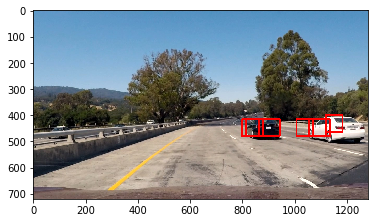

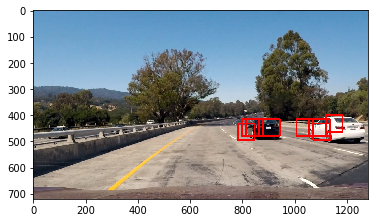

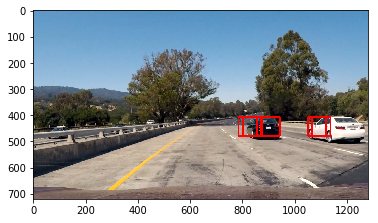

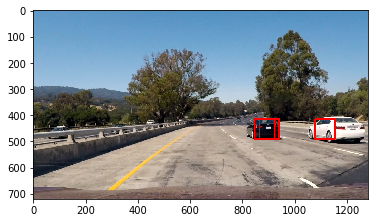

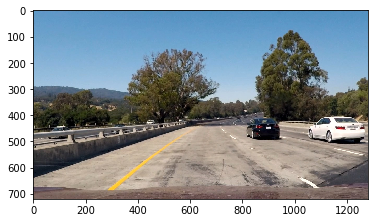

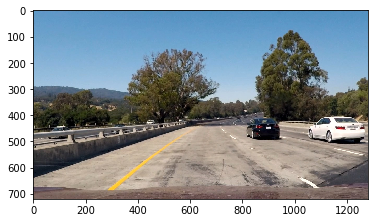

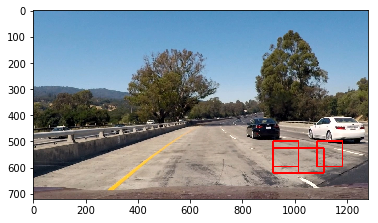

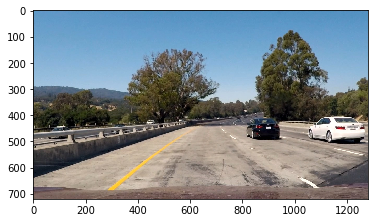

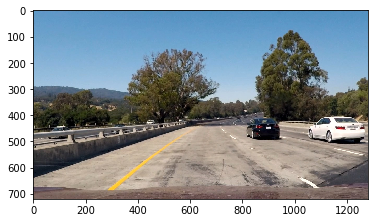

In [228]:
img = cv2.imread('./test_images/test1.jpg')
rectangles = []
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2

hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial = 32
spatial_size = (spatial,spatial)
hist_bins = 32

ystart = [400,400,408,416,432,448,500,500,500]
ystop = [496,512,496,512,528,544,660,720,720]
myscalelist = [1.0, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0,2.5]
i=0
for scale in myscalelist:
    out_img, rect = find_cars(img, ystart[i], ystop[i], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,colorspace)
    rectangles+=rect
    plt.figure(i+1)
    plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
    i=i+1
    print ("end scan on scale %f" % scale)
print ("end scan on image")

# ystart = 400
# ystop = 500
# scale = 1.0
# out_img, rect = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,colorspace)
# rectangles+=rect


# fig = plt.figure(figsize=(100,30))
# plt.subplot(611)
# out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
# plt.imshow(out_img)


# ystart = 400
# ystop = 600
# scale = 1.5
# out_img, rect = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,colorspace)
# rectangles+=rect

# fig = plt.figure(figsize=(100,30))
# plt.subplot(621)
# out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
# plt.imshow(out_img)


# ystart = 500
# ystop = 600
# scale = 2.5
# out_img, rect = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,colorspace)
# rectangles+=rect

# fig = plt.figure(figsize=(100,30))
# plt.subplot(631)
# out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
# plt.imshow(out_img)

# Heatmap

This method (duplicated from lesson material) produces a heat map based on rectangle locations (additive with overlap).


In [229]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

#


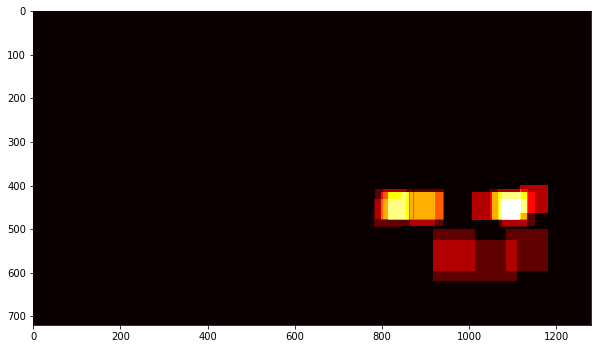

In [230]:
#img = mpimg.imread('./test_images/test1.jpg')

#print (rectangles)
# Test out the heatmap
heatmap_img = np.zeros_like(img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('#')

# Heatmap Thresholding

...


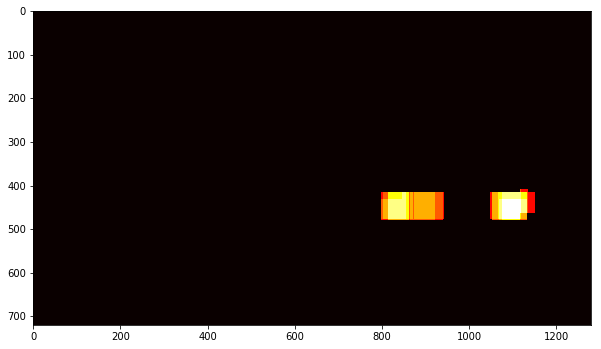

In [231]:
heatmap_img = apply_threshold(heatmap_img, 2)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

# Labels to Heatmap


2 cars found


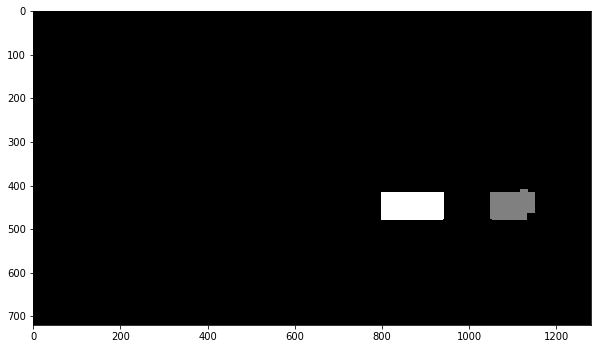

In [232]:
from scipy.ndimage.measurements import label

labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

# Draw Bounding Boxes for Lables


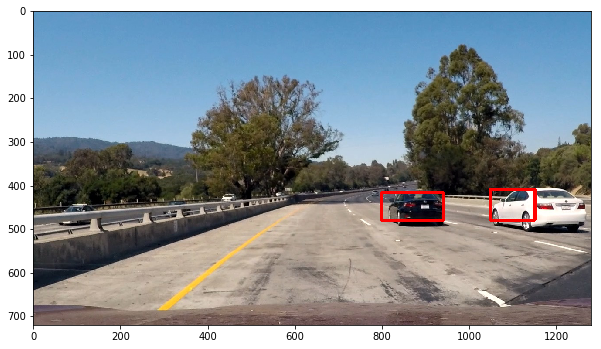

In [233]:
def draw_labeled_bboxes(img, labels): # adapted from https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/de41bff0-ad52-493f-8ef4-5506a279b812
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))

# Tracking Pipeline

In [247]:
def process_frame(img):

    rectangles = []
    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial = 32
    spatial_size = (spatial,spatial)
    hist_bins = 32

#     ystart = [400,432,500,500]
#     ystop = [496,592,660,720]
#     myscalelist = [1.0, 1.5, 2.0, 2.5]
    
    ystart = [400,408,416,432,448,500,500,500]
    ystop = [512,496,512,528,544,660,720,720]
    myscalelist = [1.2, 1.0, 1.4, 1.6, 1.8, 1.9, 2.0,2.3]

    i=0
    for scale in myscalelist:
        out_img, rect = find_cars(img, ystart[i], ystop[i], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,colorspace)
        rectangles+=rect
        #plt.figure(i+1)
        #plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
        #i=i+1
        #print ("end scan on scale %f" % scale)
    #print ("end scan on image")
    
    
#     ystart = 400
#     ystop = 500
#     scale = 1.0
#     out_img, rect = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,colorspace)
#     rectangles+=rect

#     ystart = 400
#     ystop = 600
#     scale = 1.5
#     out_img, rect = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,colorspace)
#     rectangles+=rect

#     ystart = 500
#     ystop = 600
#     scale = 2.5
#     out_img, rect = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,colorspace)
#     rectangles+=rect

    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 2)
    labels = label(heatmap_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('#')

#


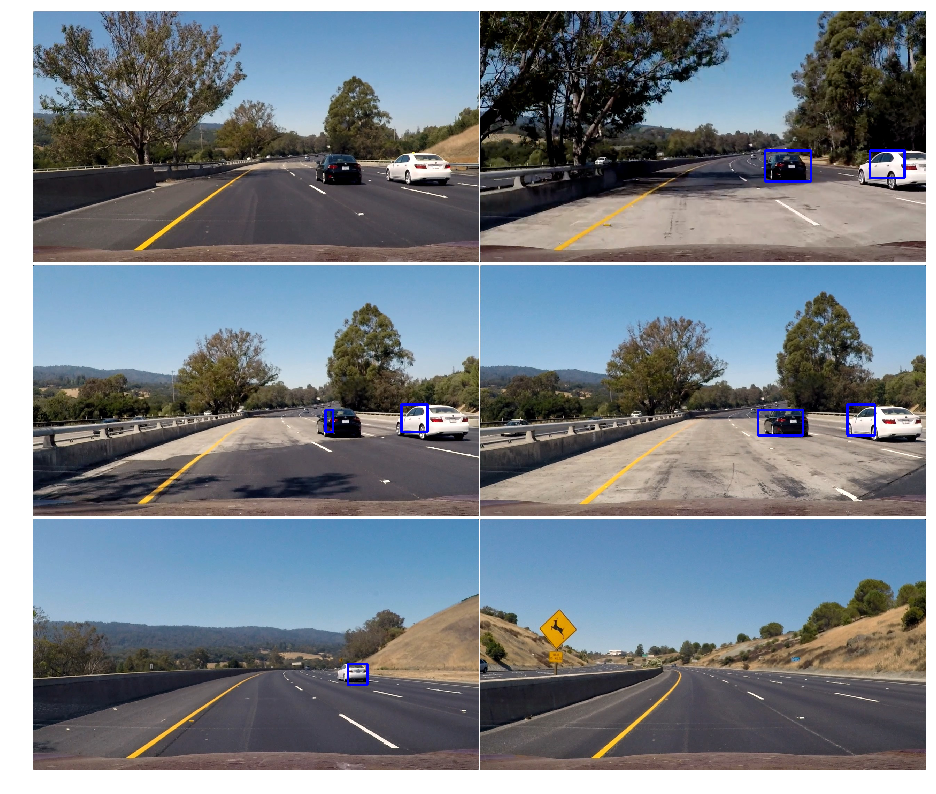

In [248]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(cv2.imread(im)))
    axs[i].axis('off')

# Test Pipeline on Video

In [249]:
from moviepy.editor import VideoFileClip

#test_out_file = 'project_video_out.mp4'
#clip_test = VideoFileClip('project_video.mp4')
#clip_test_out = clip_test.fl_image(process_frame)
#%time clip_test_out.write_videofile(test_out_file, audio=False)

In [301]:
def process_frame_with_track(img):

    rectangles = []
    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial = 32
    spatial_size = (spatial,spatial)
    hist_bins = 32

    ystart = [400,408,500,500]
    ystop = [496,528,660,720]
    myscalelist = [1.0,1.5,2.0,2.5]
  
    
#     ystart = [400,408,416,432,448,500,500,500]
#     ystop = [512,496,512,528,544,660,660,720]
#     myscalelist = [1.0, 1.0, 1.5, 1.5, 2.0, 2.0, 2.5,2.5]

    i=0
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for scale in myscalelist:
        out_img, rect = find_cars(img, ystart[i], ystop[i], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,colorspace)
        rectangles+=rect
    
#     ystart = 400
#     ystop = 500
#     scale = 1.0
#     out_img, rect = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,colorspace)
#     rectangles+=rect

#     ystart = 400
#     ystop = 600
#     scale = 1.5
#     out_img, rect = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,colorspace)
#     rectangles+=rect

#     ystart = 500
#     ystop = 600
#     scale = 2.5
#     out_img, rect = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,colorspace)
#     rectangles+=rect
    
    
#     heatmap_img = np.zeros_like(img[:,:,0]).astype(np.float)
#     combined_heatmap_img = add_heat(heatmap_img,rectangles)
#     trac.append(combined_heatmap_img)
#     combined_heatmap_img = np.average(trac, axis=0)
#     combined_threshold = apply_threshold(combined_heatmap_img,2)
#     labels = label(combined_threshold)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    
    trac.append(rectangles)
    heatmap_img = np.zeros_like(img[:,:,0])
    for cars in trac:
        combined_heatmap_img = add_heat(heatmap_img, cars)
    combined_threshold = apply_threshold(combined_heatmap_img, 1 + ((len(trac)*2)//3))
    labels = label(combined_threshold)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
print('#')

#


In [303]:
from moviepy.editor import VideoFileClip
import itertools 
from collections import deque
trac = deque(maxlen = 25)
test_out_file = 'project_video_out_tracking_hope.mp4'
clip_test = VideoFileClip('project_video.mp4')#.subclip(45,50)
clip_test_out = clip_test.fl_image(process_frame_with_track)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out_tracking_hope.mp4
[MoviePy] Writing video project_video_out_tracking_hope.mp4


100%|█████████▉| 1260/1261 [12:26<00:00,  1.89it/s]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_tracking_hope.mp4 

CPU times: user 7min 36s, sys: 26.4 s, total: 8min 2s
Wall time: 12min 29s
